# Preliminares

1. **Importar las librerías necesarias:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics



2. **Cargar los datos desde un archivo Excel:**



In [2]:
df = pd.read_excel('/home/danielcardenas/MAD/MAD/Series de Tiempo/Deterioro/base ajustada.xlsx')
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%y')
df.set_index('Fecha', inplace=True)



3. **Explorar los datos:**



In [3]:
print(df.head())
print(df.describe())

                   valor       PIB     IPC  SMMLV
Fecha                                            
2016-01-31  9.009609e+08  0.023750  0.0589  0.045
2016-02-29  9.314697e+08  0.023750  0.0589  0.045
2016-03-31  9.770731e+08  0.023750  0.0589  0.045
2016-04-30  1.031098e+09  0.022473  0.0589  0.045
2016-05-31  7.553645e+08  0.022473  0.0589  0.045
              valor         PIB         IPC       SMMLV
count  1.060000e+02  106.000000  106.000000  106.000000
mean   9.889677e+08    0.025165    0.040521    0.071664
std    1.043912e+09    0.044932    0.026950    0.033533
min    2.012596e+08   -0.085640    0.002500    0.035000
25%    5.249336e+08    0.012111    0.019775    0.059000
50%    7.251064e+08    0.020874    0.036800    0.060000
75%    1.091591e+09    0.032395    0.058900    0.070000
max    7.729563e+09    0.108012    0.126900    0.160000


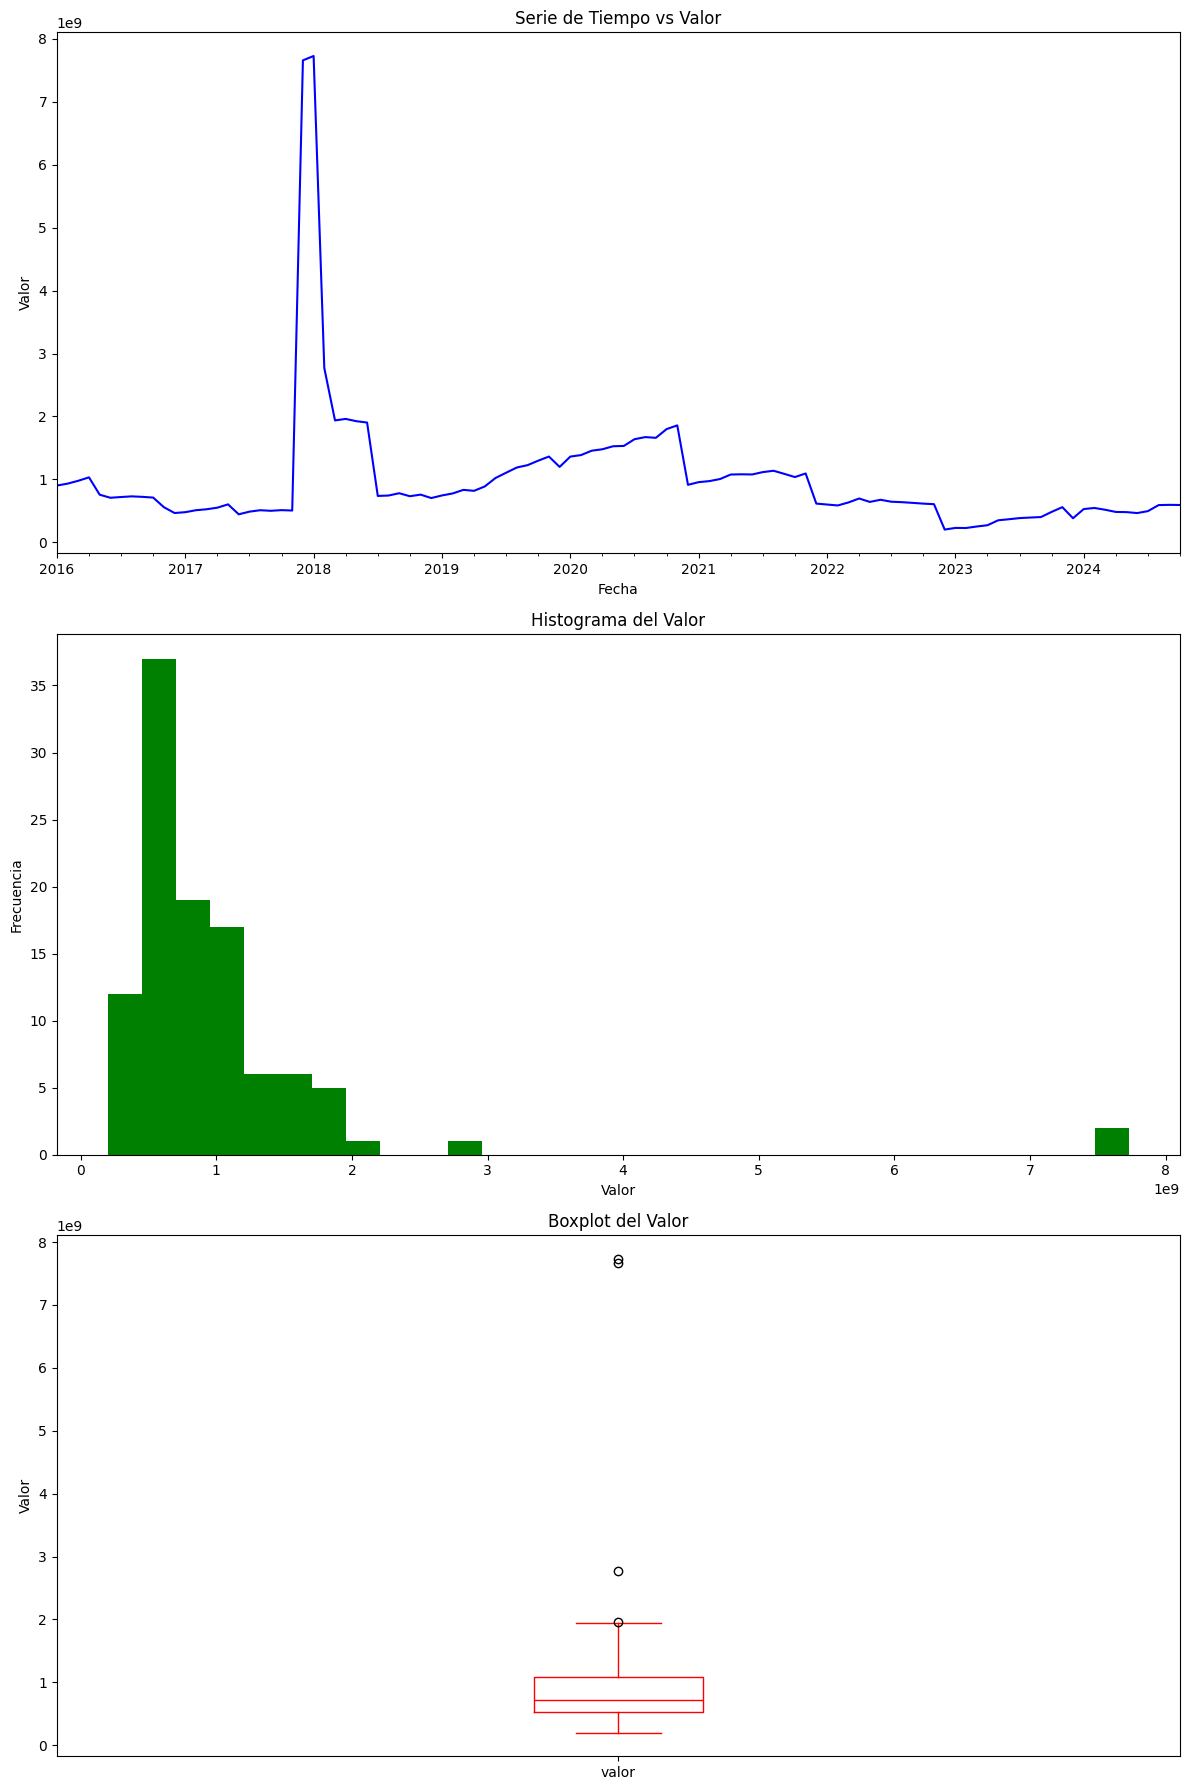

In [4]:
# Crear la figura y los ejes
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Graficar la serie de tiempo vs el valor
df['valor'].plot(ax=axes[0], title='Serie de Tiempo vs Valor', color='blue')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valor')

# Graficar el histograma del valor
df['valor'].plot(kind='hist', bins=30, ax=axes[1], title='Histograma del Valor', color='green')
axes[1].set_xlabel('Valor')
axes[1].set_ylabel('Frecuencia')

# Graficar el boxplot del valor
df['valor'].plot(kind='box', ax=axes[2], title='Boxplot del Valor', color='red')
axes[2].set_ylabel('Valor')

# Mostrar los gráficos
plt.tight_layout()
plt.show()



4. **Visualizar las relaciones entre las variables:**



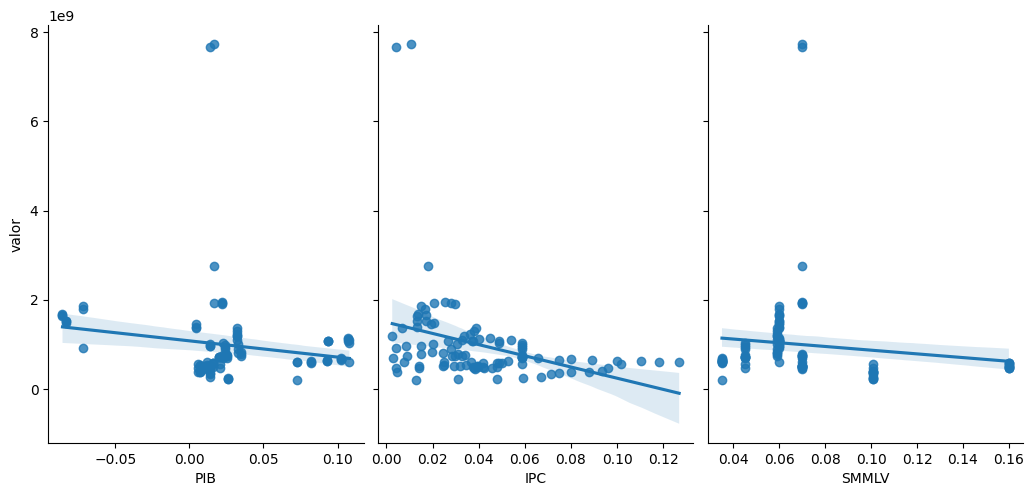

In [5]:
sns.pairplot(df, x_vars=['PIB', 'IPC', 'SMMLV'], y_vars='valor', height=5, aspect=0.7, kind='reg')
plt.show()



5. **Calcular la correlación:**



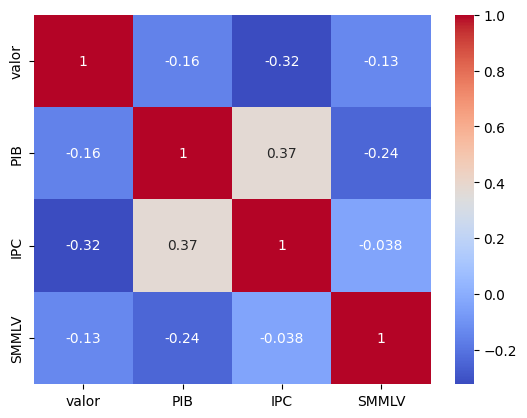

In [6]:
correlation_matrix = df[['valor', 'PIB', 'IPC', 'SMMLV']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Regresión multiple



6. **Dividir los datos en conjuntos de entrenamiento y prueba:**



In [7]:
X = df[['PIB', 'IPC', 'SMMLV']]
y = df['valor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)



7. **Ajustar un modelo de regresión lineal múltiple:**



In [8]:
X_train_const = sm.add_constant(X_train)  # Agregar una constante al modelo
model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  valor   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     3.177
Date:                Wed, 25 Dec 2024   Prob (F-statistic):             0.0285
Time:                        12:47:24   Log-Likelihood:                -1864.8
No. Observations:                  84   AIC:                             3738.
Df Residuals:                      80   BIC:                             3747.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.803e+08   9.12e+08      0.746      0.4



8. **Hacer predicciones en el conjunto de prueba:**



In [9]:
X_test_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_const)



9. **Visualizar la comparación entre los datos de entrenamiento, prueba y predicción:**



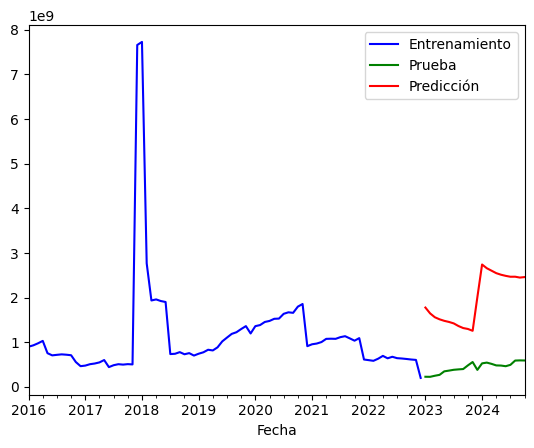

In [10]:
# Crear la figura y los ejes
fig, ax = plt.subplots()

# Graficar los datos de entrenamiento
y_train.plot(ax=ax, label='Entrenamiento', color='blue')

# Graficar los datos de prueba
y_test.plot(ax=ax, label='Prueba', color='green')

# Convertir y_pred a pandas.Series si es un numpy.ndarray
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Graficar las predicciones
y_pred_series.plot(ax=ax, label='Predicción', color='red')

# Añadir la leyenda
ax.legend()

# Mostrar la gráfica
plt.show()



10. **Interpretar los resultados:**

- **Coeficientes:** Indican la magnitud y dirección del efecto de cada variable independiente sobre la variable dependiente.
- **P-valores:** Indican si los coeficientes son significativamente diferentes de cero.
- **R-cuadrado:** Indica la proporción de la variabilidad en la variable dependiente explicada por las variables independientes.

11. **Conclusiones:**

- Si los coeficientes de PIB, IPC y SMMLV son significativos (p-valor < 0.05), entonces estas variables influyen en el valor.
- Si el R-cuadrado es alto, el modelo explica bien la variabilidad del valor.
- Analizar los gráficos de dispersión y la matriz de correlación para entender mejor las relaciones entre las variables.


# Prophet

Para realizar el análisis con Prophet, puedes seguir estos pasos:

1. **Importar las librerías necesarias:**





6. **Preparar los datos para Prophet:**

Prophet requiere que los datos tengan columnas específicas: `ds` para la fecha y `y` para el valor a predecir.



In [24]:
df_prophet = df.reset_index().rename(columns={'Fecha': 'ds', 'valor': 'y'})
df_prophet

,ds,y,PIB,IPC,SMMLV
0,2016-01-31,9.009609e+08,0.023750,0.0589,0.045
1,2016-02-29,9.314697e+08,0.023750,0.0589,0.045
2,2016-03-31,9.770731e+08,0.023750,0.0589,0.045
3,2016-04-30,1.031098e+09,0.022473,0.0589,0.045
4,2016-05-31,7.553645e+08,0.022473,0.0589,0.045
...,...,...,...,...,...
101,2024-06-30,4.636849e+08,0.014218,0.0457,0.160
102,2024-07-31,4.942029e+08,0.016221,0.0479,0.160
103,2024-08-31,5.901399e+08,0.016221,0.0478,0.160
104,2024-09-30,5.940624e+08,0.016221,0.0503,0.160




7. **Dividir los datos en conjuntos de entrenamiento y prueba:**



In [12]:
train_size = int(len(df_prophet) * 0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]



8. **Ajustar el modelo de Prophet:**



In [36]:
model = Prophet(growth='linear')
model.add_regressor('PIB')
model.add_regressor('IPC')
model.add_regressor('SMMLV')
model.fit(train)

13:03:20 - cmdstanpy - INFO - Chain [1] start processing
13:03:21 - cmdstanpy - INFO - Chain [1] done processing




9. **Hacer predicciones en el conjunto de prueba:**



In [37]:
future = model.make_future_dataframe(periods=22,freq = 'MS')
future['PIB'] = df['PIB'].values
future['IPC'] = df['IPC'].values
future['SMMLV'] = df['SMMLV'].values

forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IPC,IPC_lower,IPC_upper,PIB,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
101,2024-06-01,1.340310e+09,3.374873e+09,6.036213e+09,1.340310e+09,1.340310e+09,5.665563e+07,5.665563e+07,5.665563e+07,5.577744e+07,...,3.436625e+09,3.436625e+09,3.436625e+09,-5.662032e+07,-5.662032e+07,-5.662032e+07,0.0,0.0,0.0,4.720315e+09
102,2024-07-01,1.344782e+09,3.167414e+09,5.814653e+09,1.344782e+09,1.344783e+09,7.061930e+07,7.061930e+07,7.061930e+07,4.786436e+07,...,3.442676e+09,3.442676e+09,3.442676e+09,-3.236682e+08,-3.236682e+08,-3.236682e+08,0.0,0.0,0.0,4.463790e+09
103,2024-08-01,1.349404e+09,3.615562e+09,6.172459e+09,1.349404e+09,1.349404e+09,6.998458e+07,6.998458e+07,6.998458e+07,4.786436e+07,...,3.442041e+09,3.442041e+09,3.442041e+09,8.338057e+07,8.338057e+07,8.338057e+07,0.0,0.0,0.0,4.874826e+09
104,2024-09-01,1.354025e+09,3.469879e+09,6.050344e+09,1.354025e+09,1.354025e+09,8.585239e+07,8.585239e+07,8.585239e+07,4.786436e+07,...,3.457909e+09,3.457909e+09,3.457909e+09,-6.860534e+07,-6.860534e+07,-6.860534e+07,0.0,0.0,0.0,4.743329e+09
105,2024-10-01,1.358498e+09,3.174332e+09,5.809857e+09,1.358497e+09,1.358498e+09,7.696642e+07,7.696642e+07,7.696642e+07,4.873648e+07,...,3.449895e+09,3.449895e+09,3.449895e+09,-3.162588e+08,-3.162588e+08,-3.162588e+08,0.0,0.0,0.0,4.492134e+09


/home/danielcardenas/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/danielcardenas/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


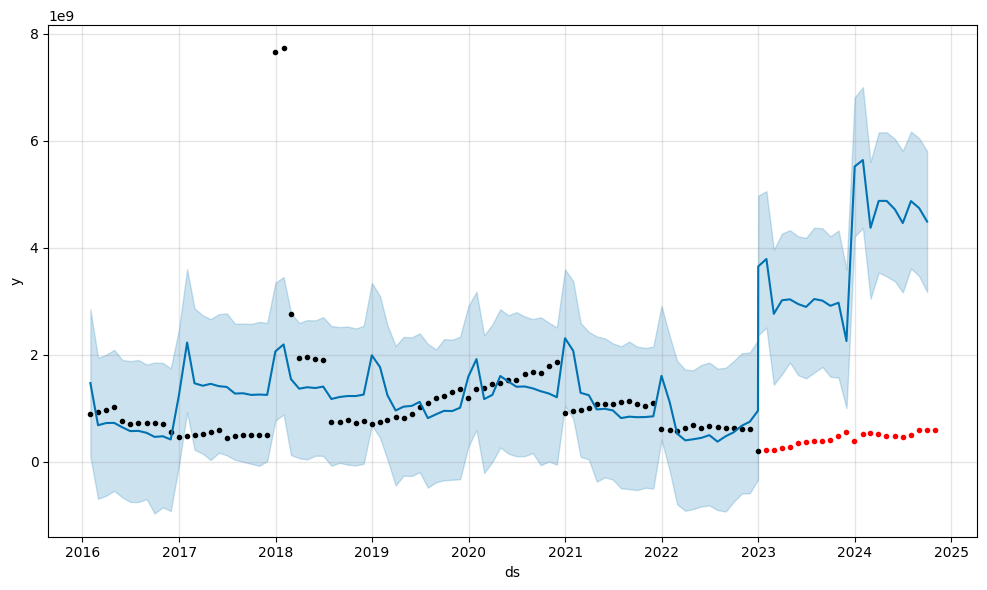

In [40]:
fig = model.plot(forecast)
ax= fig.gca()
ax.plot(test['ds'],test['y'],'r.')



10. **Visualizar la comparación entre los datos de entrenamiento, prueba y predicción:**



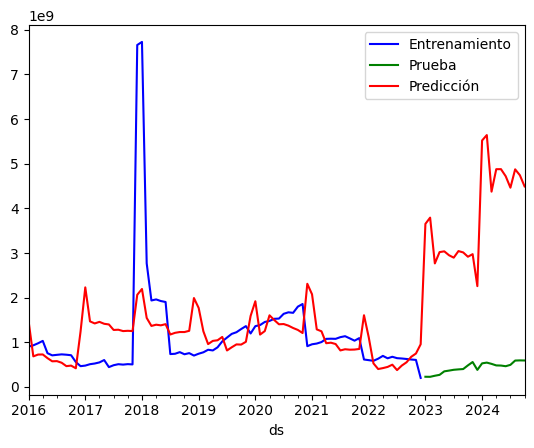

In [41]:
# Crear la figura y los ejes
fig, ax = plt.subplots()

# Graficar los datos de entrenamiento
train.set_index('ds')['y'].plot(ax=ax, label='Entrenamiento', color='blue')

# Graficar los datos de prueba
test.set_index('ds')['y'].plot(ax=ax, label='Prueba', color='green')

# Graficar las predicciones
forecast.set_index('ds')['yhat'].plot(ax=ax, label='Predicción', color='red')

# Añadir la leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [47]:
df_p_cv = cross_validation(model, initial='720 days',period='180 days',horizon='180 days')
df_p_cv.tail()

  0%|          | 0/10 [00:00<?, ?it/s]

13:13:46 - cmdstanpy - INFO - Chain [1] start processing


13:14:12 - cmdstanpy - INFO - Chain [1] done processing
13:14:12 - cmdstanpy - INFO - Chain [1] start processing
13:14:13 - cmdstanpy - INFO - Chain [1] done processing
13:14:13 - cmdstanpy - INFO - Chain [1] start processing
13:14:13 - cmdstanpy - INFO - Chain [1] done processing
13:14:14 - cmdstanpy - INFO - Chain [1] start processing
13:14:14 - cmdstanpy - INFO - Chain [1] done processing
13:14:14 - cmdstanpy - INFO - Chain [1] start processing
13:14:15 - cmdstanpy - INFO - Chain [1] done processing
13:14:15 - cmdstanpy - INFO - Chain [1] start processing
13:14:15 - cmdstanpy - INFO - Chain [1] done processing
13:14:16 - cmdstanpy - INFO - Chain [1] start processing
13:14:16 - cmdstanpy - INFO - Chain [1] done processing
13:14:17 - cmdstanpy - INFO - Chain [1] start processing
13:14:17 - cmdstanpy - INFO - Chain [1] done processing
13:14:18 - cmdstanpy - INFO - Chain [1] start processing
13:14:18 - cmdstanpy - INFO - Chain [1] done processing
13:14:18 - cmdstanpy - INFO - Chain [1] 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
55,2022-08-31,3.356943e+08,-1.001761e+09,1.775414e+09,6.365655e+08,2022-07-04
56,2022-09-30,3.897834e+08,-1.018782e+09,1.669894e+09,6.256414e+08,2022-07-04
57,2022-10-31,5.037890e+08,-8.685690e+08,1.778252e+09,6.136156e+08,2022-07-04
58,2022-11-30,5.669698e+08,-7.501907e+08,1.904903e+09,6.047373e+08,2022-07-04
59,2022-12-31,1.221554e+09,-1.035811e+08,2.606039e+09,2.012596e+08,2022-07-04


In [44]:
df_per = performance_metrics(df_p_cv)
df_per.tail(6)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
93,351 days,1.874255e+20,1.369034e+10,8.975939e+09,6.455395,4.665940,1.535028,0.4
94,355 days,1.421588e+20,1.192304e+10,8.017144e+09,6.655607,4.665940,1.536746,0.4
95,356 days,1.260685e+20,1.122802e+10,6.821067e+09,6.040775,2.020547,1.433430,0.5
96,360 days,1.260868e+20,1.122884e+10,6.831687e+09,6.114679,2.020547,1.464325,0.5
97,361 days,1.261202e+20,1.123032e+10,6.848480e+09,6.191154,2.044285,1.521637,0.5
98,365 days,1.261181e+20,1.123023e+10,6.847457e+09,6.524571,3.687629,1.463533,0.5


/home/danielcardenas/.local/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/danielcardenas/.local/lib/python3.10/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


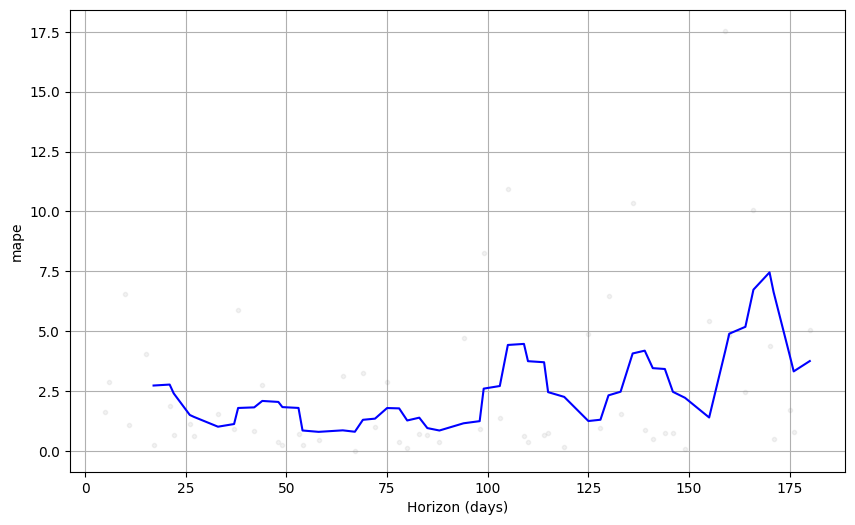

In [48]:
fig = plot_cross_validation_metric(df_p_cv, metric='mape')
plt.show()



11. **Interpretar los resultados:**

- **Coeficientes de regresores:** Prophet no proporciona coeficientes de regresores directamente, pero puedes evaluar la importancia de los regresores observando cómo afectan las predicciones.
- **Gráficos de componentes:** Prophet proporciona gráficos de componentes que muestran la tendencia, estacionalidad y efectos de los regresores.

12. **Conclusiones:**

- Analizar los gráficos de dispersión y la matriz de correlación para entender mejor las relaciones entre las variables.
- Evaluar la precisión de las predicciones comparando los valores reales con los valores predichos.

Siguiendo estos pasos, podrás aplicar un modelo de Prophet para validar si las variables PIB, IPC y SMMLV influyen en el valor y obtener conclusiones basadas en los resultados del análisis. Además, la gráfica te permitirá visualizar la comparación entre los datos de entrenamiento, prueba y predicción de manera correcta.